# Construcción y Entrenamiento de Embeddings desde Cero con PyTorch

# 1. Preparación de Datos y Creación del Vocabulario

Lo primero es conseguir el texto crudo, limpiarlo de caracteres extraños (saltos de línea, puntuación rara) y construir nuestro diccionario (vocabulario).
También definimos los mapas `word2idx` (palabra -> número) e `idx2word` (número -> palabra).

In [1]:
# Librerías típicas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests
import re
import string

# PyTorch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

# Instalación de torchinfo si es necesario
try:
    from torchinfo import summary
except ImportError:
    !pip install torchinfo
    from torchinfo import summary

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# --- Obtener y limpiar el texto ---
# Descargar texto de Gutenberg (La Máquina del Tiempo)
text = requests.get('https://www.gutenberg.org/files/35/35-0.txt').text

# Caracteres a reemplazar con espacios
strings2replace = [ '\r\n\r\nâ\x80\x9c','â\x80\x9c','â\x80\x9d','\r\n','â\x80\x94','â\x80\x99','â\x80\x98','_', ]

# Reemplazo usando expresiones regulares
for str2match in strings2replace:
  text = re.compile(r'%s'%str2match).sub(' ', text)

# Eliminar caracteres no ASCII y números, y pasar a minúsculas
text = re.sub(r'[^\x00-\x7F]+', ' ', text)
text = re.sub('\d+', '', text).lower()

# Dividir en palabras (lexicon)
words = re.split(f'[{string.punctuation}\s]+', text)
words = [item.strip() for item in words if item.strip()] # Eliminar vacíos
words = [item for item in words if len(item)>1] # Eliminar letras sueltas

# Crear vocabulario
vocab  = sorted(set(words))
nWords = len(words)
nVocab = len(vocab)

# Diccionarios de conversión
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for i,w in enumerate(vocab)}

print(f'El libro contiene {nWords:,} palabras, de las cuales {nVocab:,} son únicas (vocabulario).')
print(f'\nPrimeras 10 palabras del vocabulario:\n', list(word2idx.keys())[:10])

<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:41: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3668105521.py:38: SyntaxWarning: invalid escape sequence '\d'
  text = re.sub('\d+', '', text).lower()
/tmp/ipython-input-3668105521.py:41: SyntaxWarning: invalid escape sequence '\s'
  words = re.split(f'[{string.punctuation}\s]+', text)


El libro contiene 30,698 palabras, de las cuales 4,589 son únicas (vocabulario).

Primeras 10 palabras del vocabulario:
 ['abandon', 'abandoned', 'able', 'abnormally', 'abominable', 'abominations', 'about', 'above', 'abruptly', 'absence']


# 2. Creación del Dataset y DataLoader

Para entrenar modelos de lenguaje, usamos una "ventana deslizante".
* **Input:** Una secuencia de palabras (contexto).
* **Target:** La siguiente palabra en la secuencia.

Crearemos una clase personalizada `WordDataset` que hereda de `torch.utils.data.Dataset` para manejar esto eficientemente.

In [2]:
# Crear una clase para el objeto Dataset
class WordDataset(Dataset):
  def __init__(self, text, word2idx, context_length=8, stride=4):
    # Inicialización
    self.inputs  = []
    self.targets = []
    self.word2idx = word2idx

    # Generar secuencias superpuestas (Ventana deslizante)
    for i in range(0, len(text) - context_length, stride):
      # Obtener ventana de palabras
      in_seq   = text[i : i + context_length]
      targ_seq = text[i + 1 : i + context_length + 1] # Target desplazado 1 paso

      # Convertir a índices y guardar como tensores
      self.inputs.append(torch.tensor([word2idx[w] for w in in_seq]))
      self.targets.append(torch.tensor([word2idx[w] for w in targ_seq]))

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

# --- Instanciar el Dataset y DataLoader ---
context_length = 6 # Longitud del contexto
stride = 3         # Salto entre ventanas

text_dataset = WordDataset(words, word2idx, context_length, stride)

# Crear el DataLoader (para manejar batches)
dataloader = DataLoader(
                text_dataset,
                batch_size = 32,
                shuffle    = True,
                drop_last  = True
            )

# Inspeccionar un batch
X, y = next(iter(dataloader))
print('Inputs (índices):', X.shape)
print('Targets (índices):', y.shape)

print('\nInputs en palabras (primer ejemplo del batch):')
print([idx2word[item.item()] for item in X[0]])
print('Targets en palabras (primer ejemplo del batch):')
print([idx2word[item.item()] for item in y[0]])

Inputs (índices): torch.Size([32, 6])
Targets (índices): torch.Size([32, 6])

Inputs en palabras (primer ejemplo del batch):
['about', 'matches', 'where', 'is', 'my', 'time']
Targets en palabras (primer ejemplo del batch):
['matches', 'where', 'is', 'my', 'time', 'machine']


# 3. Definición de la Arquitectura (Embedding Model)

Aquí definimos la red neuronal.
1.  **Capa Embedding:** Convierte índices (enteros) en vectores densos. Es la matriz que queremos aprender.
2.  **Capas Lineales:** Procesan la información.
3.  **Salida:** Un vector del tamaño del vocabulario con `LogSoftmax` para predecir la probabilidad de la siguiente palabra.

In [3]:
# Dimensión del espacio de embedding (arbitraria)
embeddingDimension = 100

class EmbeddingModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_size):
    super(EmbeddingModel, self).__init__()

    # 1. Capa de Embedding (la que nos interesa)
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    # 2. Capas Lineales (transformación)
    # Entrada: Contexto aplanado (context_size * embedding_dim)
    self.linear1 = nn.Linear(context_size * embedding_dim, 128)
    self.linear2 = nn.Linear(128, vocab_size)

  def forward(self, inputs):
    # a. Obtener embeddings y aplanar: [batch, context, emb_dim] -> [batch, context*emb_dim]
    embeds = self.embeddings(inputs).view(inputs.shape[0], -1)

    # b. Capas densas + ReLU
    out = F.relu(self.linear1(embeds))
    out = self.linear2(out)

    # c. Log Softmax (para clasificación multiclase)
    log_probs = F.log_softmax(out, dim=1)
    return log_probs

# Instanciar modelo
model = EmbeddingModel(vocab_size=nVocab, embedding_dim=embeddingDimension, context_size=context_length)

# Inicialización de pesos (Xavier) para mejor convergencia
for param in model.parameters():
  if param.dim() > 1: # Excluye biases
    nn.init.xavier_normal_(param)

# Resumen del modelo
print(model)

EmbeddingModel(
  (embeddings): Embedding(4589, 100)
  (linear1): Linear(in_features=600, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=4589, bias=True)
)


# 4. Entrenamiento del Modelo

Configuramos el dispositivo (GPU si es posible), la función de pérdida (`NLLLoss` porque la salida es LogSoftmax) y el optimizador (`AdamW`).

Guardamos una copia de los embeddings **antes** de entrenar para comparar después.

Usando dispositivo: cpu
Iniciando entrenamiento...
  Epoch 1/20 finalizada. Loss: 6.9691
  Epoch 2/20 finalizada. Loss: 6.0308
  Epoch 3/20 finalizada. Loss: 5.6033
  Epoch 4/20 finalizada. Loss: 5.2508
  Epoch 5/20 finalizada. Loss: 4.9206
  Epoch 6/20 finalizada. Loss: 4.5789
  Epoch 7/20 finalizada. Loss: 4.2018
  Epoch 8/20 finalizada. Loss: 3.7725
  Epoch 9/20 finalizada. Loss: 3.2817
  Epoch 10/20 finalizada. Loss: 2.7320
  Epoch 11/20 finalizada. Loss: 2.1229
  Epoch 12/20 finalizada. Loss: 1.4913
  Epoch 13/20 finalizada. Loss: 0.9057
  Epoch 14/20 finalizada. Loss: 0.4884
  Epoch 15/20 finalizada. Loss: 0.2463
  Epoch 16/20 finalizada. Loss: 0.1247
  Epoch 17/20 finalizada. Loss: 0.0690
  Epoch 18/20 finalizada. Loss: 0.0419
  Epoch 19/20 finalizada. Loss: 0.0285
  Epoch 20/20 finalizada. Loss: 0.0205


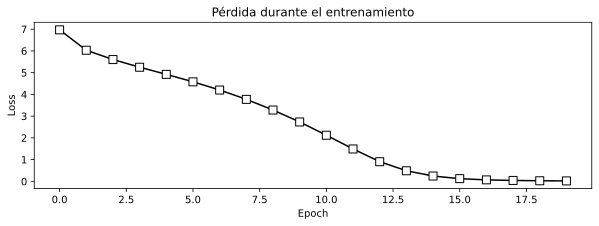

In [4]:
# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Mover modelo a GPU
model = model.to(device)

# Función de pérdida y optimizador
loss_function = nn.NLLLoss().to(device) # Negative Log Likelihood
optimizer = torch.optim.AdamW(model.parameters(), lr=.001, weight_decay=.01)

# Guardar copia de embeddings pre-entrenados
pretrained_embeddings = model.embeddings.weight.detach().cpu().clone()

# --- Bucle de Entrenamiento ---
def trainTheModel(model, num_epochs=25):
  total_loss = np.zeros(num_epochs)

  for epoch in range(num_epochs):
    epoch_loss = 0

    for X, y in dataloader:
      # Mover a GPU
      X, y = X.to(device), y.to(device)

      # 1. Forward
      model.zero_grad()
      log_probs = model(X)

      # 2. Calcular pérdida (solo contra la última palabra del target)
      # Nota: y[:, -1] es la palabra que intentamos predecir al final de la secuencia
      loss = loss_function(log_probs, y[:, -1])

      # 3. Backward
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    # Promedio de pérdida por época
    total_loss[epoch] = epoch_loss / len(dataloader)
    print(f'  Epoch {epoch+1}/{num_epochs} finalizada. Loss: {total_loss[epoch]:.4f}')

  return model, total_loss

# ¡Entrenar!
print("Iniciando entrenamiento...")
model, total_loss = trainTheModel(model, num_epochs=20)

# Graficar pérdida
plt.figure(figsize=(10, 3))
plt.plot(total_loss, 'ks-', markerfacecolor='w', markersize=8)
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.show()

# Guardar embeddings post-entrenamiento
postrained_embeddings = model.embeddings.weight.detach().cpu().clone()

# 5. Análisis: ¿Qué aprendió el modelo? (Code Challenge)

Comparamos los pesos antes y después.
1.  **Distribución:** Los pesos entrenados suelen seguir una distribución normal más definida.
2.  **Vectores Individuales:** Ver cómo cambia el vector de una palabra aleatoria.
3.  **Similitud Semántica:** Verificar si palabras relacionadas como "time" y "machine" han aumentado su similitud coseno tras el entrenamiento.

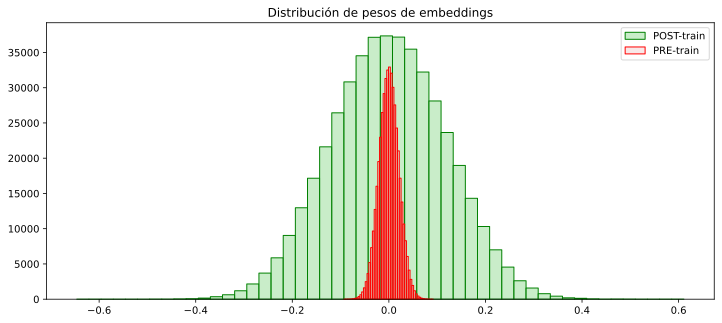

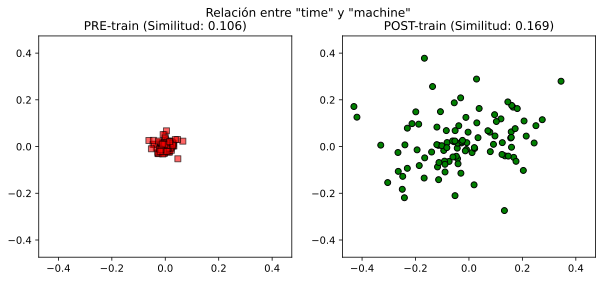

In [5]:
# --- Ejercicio 1: Distribuciones ---
yPre, xPre = np.histogram(pretrained_embeddings.flatten(), bins=50)
yPst, xPst = np.histogram(postrained_embeddings.flatten(), bins=50)
xPre = (xPre[1:]+xPre[:-1]) / 2
xPst = (xPst[1:]+xPst[:-1]) / 2

plt.figure(figsize=(12, 5))
plt.bar(xPst, yPst, width=xPst[1]-xPst[0], color=[.7,.9,.7,.7], edgecolor='g', label='POST-train')
plt.bar(xPre, yPre, width=xPre[1]-xPre[0], color=[.9,.7,.7,.3], edgecolor='r', label='PRE-train')
plt.legend(); plt.title('Distribución de pesos de embeddings')
plt.show()


# --- Ejercicio 3: Time Machine embeddings ---
word1 = 'time'
word2 = 'machine'

# Embeddings pre y post
e1_pre = pretrained_embeddings[word2idx[word1]]
e2_pre = pretrained_embeddings[word2idx[word2]]
e1_pst = postrained_embeddings[word2idx[word1]]
e2_pst = postrained_embeddings[word2idx[word2]]

# Calcular similitud coseno
cs_pre = F.cosine_similarity(e1_pre.unsqueeze(0), e2_pre.unsqueeze(0)).item()
cs_pst = F.cosine_similarity(e1_pst.unsqueeze(0), e2_pst.unsqueeze(0)).item()

# Visualizar
_, axs = plt.subplots(1, 2, figsize=(10, 4))
axlim = torch.cat((abs(e1_pre), abs(e2_pre), abs(e1_pst), abs(e2_pst))).max() * 1.1

axs[0].plot(e1_pre, e2_pre, 'ks', markerfacecolor='r', alpha=.6)
axs[0].set_title(f'PRE-train (Similitud: {cs_pre:.3f})')
axs[0].set(xlim=[-axlim, axlim], ylim=[-axlim, axlim])

axs[1].plot(e1_pst, e2_pst, 'ko', markerfacecolor='g')
axs[1].set_title(f'POST-train (Similitud: {cs_pst:.3f})')
axs[1].set(xlim=[-axlim, axlim], ylim=[-axlim, axlim])

plt.suptitle(f'Relación entre "{word1}" y "{word2}"')
plt.show()

# 6. Desafío de Estabilidad (Stability Challenge)

¿Son estables los embeddings?
Como la inicialización es aleatoria y el entrenamiento es estocástico (batches aleatorios), los **números exactos** en los vectores serán diferentes cada vez que entrenes.

Sin embargo, las **relaciones relativas** (Similitud Coseno) deberían mantenerse consistentes.

Aquí entrenamos el modelo 10 veces desde cero para comprobarlo.

** Repetición 1/5 **
  Epoch 1/10 finalizada. Loss: 6.9682
  Epoch 2/10 finalizada. Loss: 6.0435
  Epoch 3/10 finalizada. Loss: 5.6547
  Epoch 4/10 finalizada. Loss: 5.3245
  Epoch 5/10 finalizada. Loss: 4.9949
  Epoch 6/10 finalizada. Loss: 4.6343
  Epoch 7/10 finalizada. Loss: 4.2332
  Epoch 8/10 finalizada. Loss: 3.7727
  Epoch 9/10 finalizada. Loss: 3.2599
  Epoch 10/10 finalizada. Loss: 2.6989
** Repetición 2/5 **
  Epoch 1/10 finalizada. Loss: 6.9663
  Epoch 2/10 finalizada. Loss: 6.0285
  Epoch 3/10 finalizada. Loss: 5.6230
  Epoch 4/10 finalizada. Loss: 5.2836
  Epoch 5/10 finalizada. Loss: 4.9541
  Epoch 6/10 finalizada. Loss: 4.6061
  Epoch 7/10 finalizada. Loss: 4.2249
  Epoch 8/10 finalizada. Loss: 3.7955
  Epoch 9/10 finalizada. Loss: 3.3148
  Epoch 10/10 finalizada. Loss: 2.7724
** Repetición 3/5 **
  Epoch 1/10 finalizada. Loss: 6.9637
  Epoch 2/10 finalizada. Loss: 6.0312
  Epoch 3/10 finalizada. Loss: 5.6270
  Epoch 4/10 finalizada. Loss: 5.2874
  Epoch 5/10 finalizada

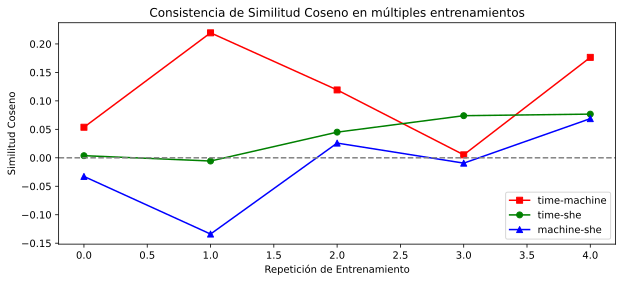

In [6]:
# Repeticiones y épocas
numRepetitions = 5 # Reducido a 5 para demostración rápida (original 10)
numEpochs = 10     # Reducido para velocidad

embeddingsMats = []
lossesMatrix = np.zeros((numRepetitions, numEpochs))

for repi in range(numRepetitions):
  # Reinicializar modelo
  model = EmbeddingModel(nVocab, embeddingDimension, context_length).to(device)
  for p in model.parameters():
    if p.dim()>1: nn.init.xavier_normal_(p)

  optimizer = torch.optim.AdamW(model.parameters(), lr=.001, weight_decay=.01)

  print(f'** Repetición {repi+1}/{numRepetitions} **')
  model, total_loss = trainTheModel(model, numEpochs)
  lossesMatrix[repi, :] = total_loss
  embeddingsMats.append(model.embeddings.weight.detach().cpu())

# --- Análisis de Consistencia ---
word1, word2, word3 = 'time', 'machine', 'she'
cossim = np.zeros((numRepetitions, 3))

for i in range(numRepetitions):
  e1 = embeddingsMats[i][word2idx[word1]]
  e2 = embeddingsMats[i][word2idx[word2]]
  e3 = embeddingsMats[i][word2idx[word3]]

  cossim[i, 0] = F.cosine_similarity(e1.unsqueeze(0), e2.unsqueeze(0)).item() # time-machine
  cossim[i, 1] = F.cosine_similarity(e1.unsqueeze(0), e3.unsqueeze(0)).item() # time-she
  cossim[i, 2] = F.cosine_similarity(e2.unsqueeze(0), e3.unsqueeze(0)).item() # machine-she

# Graficar consistencia de similitudes
plt.figure(figsize=(10, 4))
plt.plot(cossim[:,0], 's-', label=f'{word1}-{word2}', color='r')
plt.plot(cossim[:,1], 'o-', label=f'{word1}-{word3}', color='g')
plt.plot(cossim[:,2], '^-', label=f'{word2}-{word3}', color='b')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(); plt.title('Consistencia de Similitud Coseno en múltiples entrenamientos')
plt.xlabel('Repetición de Entrenamiento'); plt.ylabel('Similitud Coseno')
plt.show()